In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from  sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from  sklearn.metrics import *
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn import model_selection
import plotly.express as px
import rfpimp
import pickle

C:\Users\Develop\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning:

The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.



In [2]:
df = pd.read_csv("../data/clean/bank-additional-full_cleaned.csv")

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Drop duration

*This attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.*



In [4]:
df = df.drop('duration', axis=1)

Replace the value 'unknown' by the most frequent value.

In [5]:
categorical_columns_missing = ["loan", "housing", "job", "marital", "education", "default"]
impute_missing=SimpleImputer(missing_values='unknown', strategy='most_frequent')
df[categorical_columns_missing] = impute_missing.fit_transform(df[categorical_columns_missing])

In [6]:
#Set Datatype of Ordinal/Nominal Variables to Category
categorical_columns = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "day_of_week", "poutcome", "y"]
for col in categorical_columns:
    df[col] = df[col].astype('category')

In [7]:
df = pd.get_dummies(df, drop_first=True)

In [8]:
#rename 'y_yes' by 'y'
df.columns = list(df.columns.values[:-1]) + ["y"] 

In [9]:
X = df[df.columns[:-1]]
y = df[df.columns[-1:]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
display('check the shape of splitted train and test sets', X_train.shape, y_train.shape, X_test.shape, y_test.shape)

'check the shape of splitted train and test sets'

(32940, 46)

(32940, 1)

(8236, 46)

(8236, 1)

# Train Model for Predicting If the Customer Makes a Deposit

### Decision Tree

In [10]:
model=DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('''accuracy_score: {}
recall_score: {}
f1_score: {}
'''.format(accuracy_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))

accuracy_score: 0.832078678970374
recall_score: 0.31513903192584963
f1_score: 0.30676691729323313



### K-Folds Cross Validation

In [11]:
model=DecisionTreeClassifier()
scores = cross_validate(model, X, y, cv=5, scoring=('accuracy', 'average_precision', 'recall','f1'))
scores

{'fit_time': array([0.18786621, 0.19310117, 0.19486952, 0.22987437, 0.20489049]),
 'score_time': array([0.0149858 , 0.01499081, 0.01499414, 0.01499343, 0.01499152]),
 'test_accuracy': array([0.88732394, 0.14656952, 0.20315726, 0.11196114, 0.14061931]),
 'test_average_precision': array([0.11267606, 0.10940486, 0.10942399, 0.11184695, 0.11592755]),
 'test_recall': array([0.        , 0.02588997, 0.02693966, 0.00646552, 1.        ]),
 'test_f1': array([0.        , 0.00678349, 0.00756201, 0.00163823, 0.20776895])}

In [12]:
pickle.dump(model, open('../models/DecisionTreeModel.model', 'wb'))

### Random Forest

In [13]:
rfc = RandomForestClassifier()
rfc_scores = cross_validate(rfc, X, y.values.ravel(), cv=5, scoring=('accuracy', 'average_precision', 'recall','f1'))
rfc_scores

{'fit_time': array([2.70192528, 2.86058283, 3.10967374, 2.94520283, 3.0091362 ]),
 'score_time': array([0.12993288, 0.19989276, 0.25075388, 0.15495014, 0.1349268 ]),
 'test_accuracy': array([0.88732394, 0.34656952, 0.47868852, 0.1236187 , 0.14365513]),
 'test_average_precision': array([0.09247159, 0.08319794, 0.09059376, 0.07185191, 0.07132229]),
 'test_recall': array([0.        , 0.00755124, 0.01400862, 0.00107759, 1.        ]),
 'test_f1': array([0.        , 0.002595  , 0.00601991, 0.00027705, 0.20835204])}

In [14]:
report = pd.DataFrame(index=list(rfc_scores.keys())[2:], columns=['Decision Tree', 'Random Forest'])
for key in report.index:
  report.loc[key] = [np.mean(scores[key]), np.mean(rfc_scores[key])]

report['Improvement'] = report['Random Forest'] - report['Decision Tree']
report *= 100
report = report.astype(float).round(1)
report

,Decision Tree,Random Forest,Improvement
test_accuracy,29.8,39.6,9.8
test_average_precision,11.2,8.2,-3.0
test_recall,21.2,20.5,-0.7
test_f1,4.5,4.3,-0.1


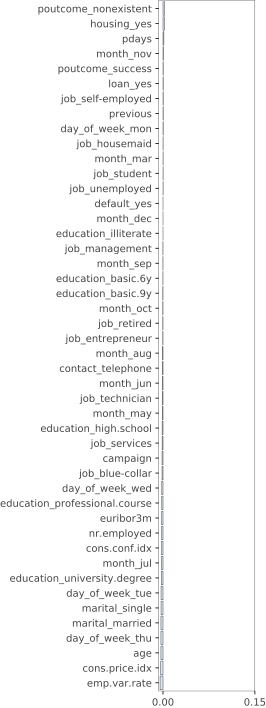

In [15]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train.values.ravel())
importance = rfpimp.importances(rfc, X_test, y_test)
rfpimp.plot_importances(importance)

In [16]:
pickle.dump(rfc, open('../models/RandomForestClassifier.model', 'wb'))